# How robustness is affected by changing activation functions (elu, kaf, kwta)  

* Craft a PGD-attack for each model from models.ipynb and evaluate robustness
* TODO: Same for a FSG attack
* Plot activations distributions in presence and absence of an attack. Do they differ?

In [1]:
# Imports
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import activationsf

In [2]:
# Load models and data
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [3]:
elu_cnn = tf.keras.models.load_model('./light_custom_models/elu_cnn')
kaf_cnn = tf.keras.models.load_model('./light_custom_models/kaf_cnn', custom_objects={'Kaf':activationsf.Kaf})
kwta_cnn = tf.keras.models.load_model('./light_custom_models/kwta_cnn', custom_objects={'Kwta':activationsf.Kwta})

In [ ]:
elu_cnn.evaluate(x_test, y_test, batch_size=32)
kaf_cnn.evaluate(x_test, y_test, batch_size=32)
kwta_cnn.evaluate(x_test, y_test, batch_size=32)

### Crafting a PGD Attack (Skip if attacks already computed in ./attacks) 

In [ ]:
# We use the IBM Adversarial Robustness 360 Toolbox
!pip install adversarial-robustness-toolbox

In [ ]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
elu_cnn_art = TensorFlowV2Classifier(model=elu_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kwta_cnn_art = TensorFlowV2Classifier(model=kwta_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kaf_cnn_art = TensorFlowV2Classifier(model=kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [ ]:
# Parameters as described in the referenced paper
pgd_elu = ProjectedGradientDescent(classifier= elu_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

pgd_kwta = ProjectedGradientDescent(classifier= kwta_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

pgd_kaf = ProjectedGradientDescent(classifier= kaf_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

In [ ]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
#!pip install ipython-autotime
%load_ext autotime

In [ ]:
# Generate pgd attacks for each classifier
# Takes around 1h each

# Get 100 random test samples
# For testing purposes use a much smaller amount of samples, e.g size = 10, 20
sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
elu_x_adv = pgd_elu.generate(x_test_sample)

sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
kwta_x_adv = pgd_kwta.generate(x_test_sample)

sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
kaf_x_adv = pgd_kaf.generate(x_test_sample)

# Save attacks
np.save('./attacks/elu_pgd.npy', elu_x_adv)
np.save('./attacks/kwta_pgd.npy', kwta_x_adv)
np.save('./attacks/kaf_pgd.npy', kaf_x_adv)

In [4]:
# Load them when kernel is restarted
elu_x_adv = np.load('./attacks/elu_pgd.npy') 
kwta_x_adv = np.load('./attacks/kwta_pgd.npy') 
kaf_x_adv = np.load('./attacks/kaf_pgd.npy') 

In [5]:
# Retrieve original image idx given a perturbed image 

def find_original_img(perturbed_img):
    
    min_diff = np.math.inf
    index = 0
    
    for i in range(0, x_test.shape[0]):
        diff = np.sum(abs(perturbed_img - x_test[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
            
    return index

### Evaluate Robustness 

In [6]:
def attack_succeed(original_img, idx, perturbed_img, model, plot = False):
    """
        Return 0 if the model has been fooled 1 otherwise
    """

    if plot:
        # Plot original img alongside with the perturbed one
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(original_img);
        ax[0].title.set_text('Original')
        ax[0].axis('off')
        ax[1].imshow(perturbed_img)
        ax[1].title.set_text('Perturbed')
        ax[1].axis('off')
        plt.show()
        plt.close()

    # Predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    original = classes[y_test[idx][0]]
    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    if plot:
        print("Real class: {}".format(original))
        print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    if original != perturbed:
        return 0
    else:
        return 1 

In [7]:
classes = ['airplane', 
           'automobile', 
            'bird', 
            'cat', 
            'deer', 
            'dog', 
            'frog', 
            'horse', 
            'ship', 
            'truck']

In [8]:
# Robustness Accuracy for elu_cnn model, set plot=True if you want image-wise stats
nfool = 0
for perturbed_img in elu_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, elu_cnn, plot=False) 

print("Robustness ELU CNN {}%".format(nfool))

Robustness ELU CNN 8%


In [9]:
# Robustness Accuracy for kwta_cnn model
nfool = 0
for perturbed_img in kwta_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kwta_cnn, plot=False) 

print("Robustness KWTA CNN {}%".format(nfool))

Robustness KWTA CNN 12%


In [10]:
# Robustness Accuracy for kaf_cnn model
nfool = 0
for perturbed_img in kaf_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kaf_cnn, plot=False) 

print("Robustness KAF CNN {}%".format((nfool)))

Robustness KAF CNN 14%


## How much does the attack affect activations ?

In [11]:
# Get the initially sampled images

def find_original_ids(perturbed_imgs):
    
    original_ids = []
    for img in perturbed_imgs:
        original_ids.append(find_original_img(img))
    
    return x_test[original_ids, :, :, :]

elu_test_sample = find_original_ids(elu_x_adv)
kaf_test_sample = find_original_ids(kaf_x_adv)
kwta_test_sample = find_original_ids(kwta_x_adv)

In [12]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, regularizers

def get_hidden_layer_input(model, l_name, inputs, fixed=False):
  ''' Build a sub model of model from buttom layer up to l_name inputs, and predict '''
  l_inp = model.get_layer(name = l_name).input
  
  if not fixed:
    hidden_model = Model(model.inputs, l_inp)
  
  else: # We need special care when the layer uses a fixed activation function 
    wgts = model.get_layer(name = l_name).get_weights()
    if 'conv' in l_name:
      
      nfilters = model.get_layer(name = l_name).filters
      #recreate the conv2d layer
      if l_name == 'conv2d': #first layer in the model need to add input_shape attribute
        out = layers.Conv2D(nfilters, 3, padding='same', name='out', activation=None, kernel_initializer='he_uniform', input_shape = (32, 32, 3)) (l_inp)
      else:
        out = layers.Conv2D(nfilters, 3, padding='same', name = 'out', activation=None, kernel_initializer='he_uniform') (l_inp)
    
    else:
      nfilters = model.get_layer(name = l_name).units
      #recreate the dense layer
      out = layers.Dense(nfilters, name = 'out', activation=None, kernel_regularizer=regularizers.l2(0.0012)) (l_inp)

    #create the new model
    hidden_model = Model(model.inputs, out)
    #set weights from old layer
    hidden_model.get_layer(name = 'out').set_weights(wgts)
  
  return hidden_model.predict(inputs)

In [15]:
# Sanity check for the latter function using kaf_cnn model
# Check that its prediction matches an adhoc model with weights loaded from the desired model

tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

kaf1_inp = get_hidden_layer_input(kaf_cnn, 'kaf_1', kaf_test_sample)

kaf_cnn_kaf1 = Sequential([
    layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3), name = 'new_conv'),
    layers.BatchNormalization(name = 'new_bn') ])

# Set weights from kaf_cnn
wgts_conv = kaf_cnn.layers[0].get_weights()
kaf_cnn_kaf1.get_layer('new_conv').set_weights(wgts_conv)

wgts_bn = kaf_cnn.layers[1].get_weights()
kaf_cnn_kaf1.get_layer('new_bn').set_weights(wgts_bn)

do_match = tf.reduce_sum(tf.cast(tf.math.logical_not(tf.equal(kaf1_inp, kaf_cnn_kaf1.predict(kaf_test_sample))), dtype=tf.float32))

print (do_match) # 0.0 for True, False otherwise

tf.Tensor(0.0, shape=(), dtype=float32)


### Display Kaf/kWTA/ELU activations with and without pgd

In [16]:
# Get Kaf's invariants: kernel bandwidth and dictionary

# Grab any kaf layer
kaf1 = kaf_cnn.get_layer(name = 'kaf_1')
# Compute delta
delta = abs(kaf1.d[0,0,0,0,1]-kaf1.d[0,0,0,0,0])
kb = 1/(6 * (delta ** 2))
# Compute d
d_tmp = tf.squeeze(kaf1.d)
d = tf.expand_dims(d_tmp, 0)

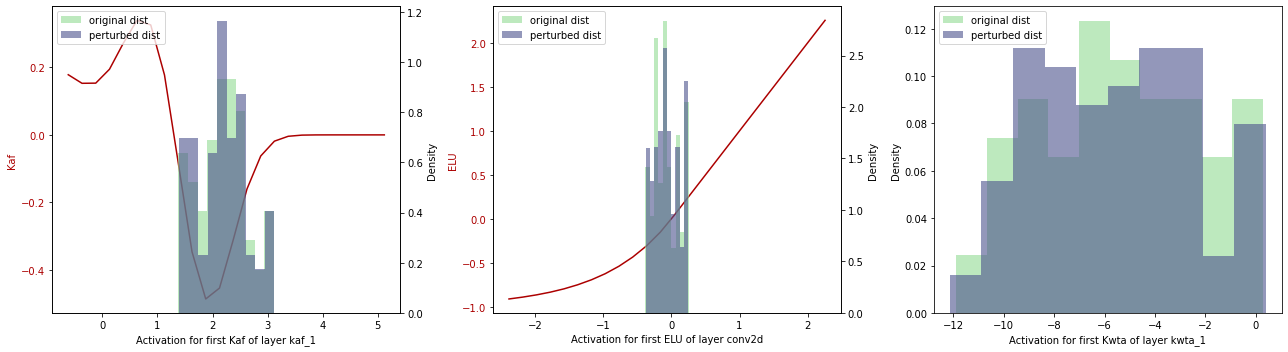

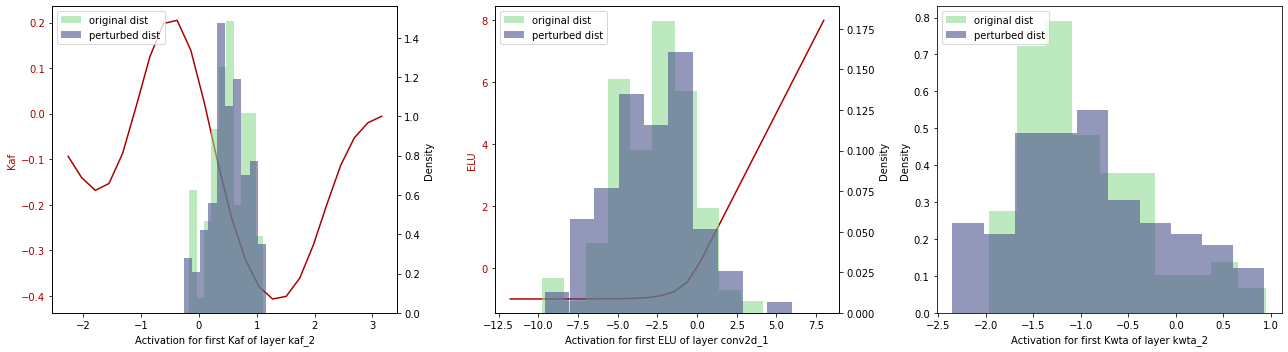

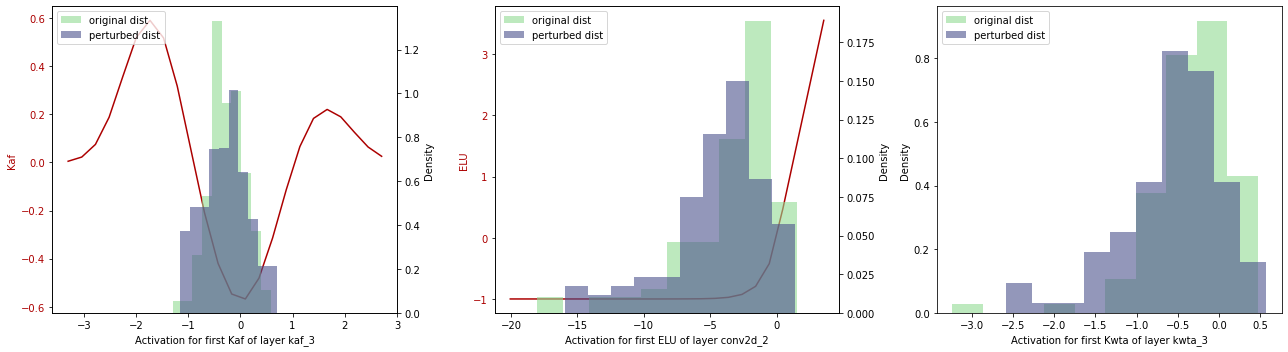

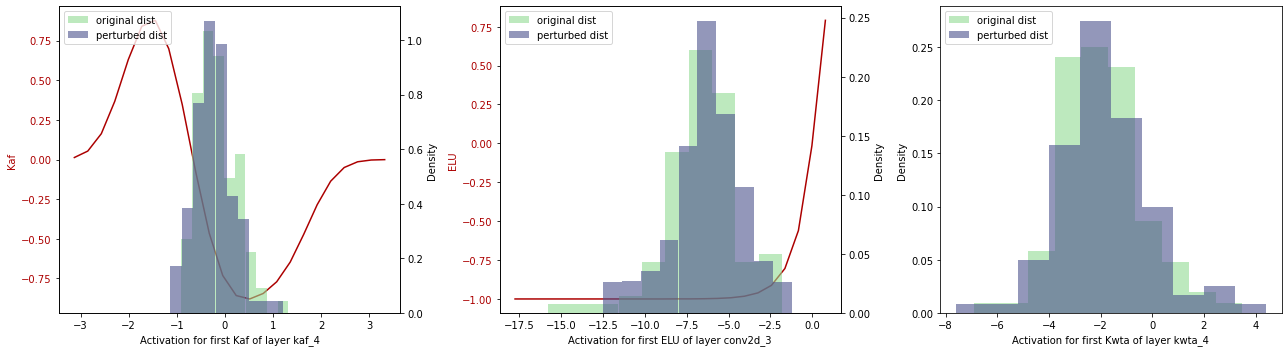

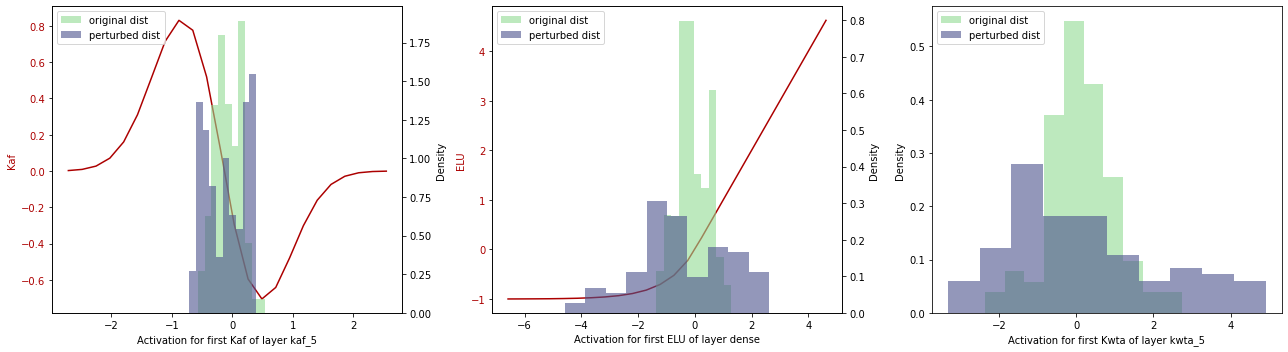

In [17]:
first = True
last = 5
for i in range(1, 6): # For each activation function 
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the batch of inputs when predicting the original sample of images and the perturbed ones
  elu_inp_orgn = get_hidden_layer_input(elu_cnn, fixed_name, elu_test_sample, fixed = True)
  elu_inp_prt = get_hidden_layer_input(elu_cnn, fixed_name, elu_x_adv, fixed = True)
  
  kwta_inp_orgn = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_test_sample)
  kwta_inp_prt = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_x_adv)
  
  kaf_inp_orgn = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_test_sample)
  kaf_inp_prt = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_x_adv)

  if kaf_inp_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the batch of first activations for the first channel
    elu_act_orgn = elu_inp_orgn[:, 0, 0, 0]
    elu_act_prt = elu_inp_prt[:, 0, 0, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0, 0, 0]
    kwta_act_prt = kwta_inp_prt[:, 0, 0, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0, 0, 0]
    kaf_act_prt = kaf_inp_prt[:, 0, 0, 0]
    
  else: # Dense layer otherwise
    
    # Get the batch of activations for the first neuron
    elu_act_orgn = elu_inp_orgn[:, 0]
    elu_act_prt = elu_inp_prt[:, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0]
    kwta_act_prt = kwta_inp_prt[:, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0]
    kaf_act_prt = kaf_inp_prt[:, 0]

  # Get mixing coefficients from the first kaf of the layer
  layer = kaf_cnn.get_layer(name = kaf_name)
  a = tf.cast( tf.expand_dims(tf.squeeze(layer.a)[0], 0), dtype = tf.float16 )

  # Input to the activation function to plot a smooth curve
  elu_act = np.concatenate((elu_act_orgn,elu_act_prt))
  min, max = np.min(elu_act), np.max(elu_act)
  elux = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  kaf_act = np.concatenate((kaf_act_orgn,kaf_act_prt))
  min, max = np.min(kaf_act), np.max(kaf_act)
  kafx = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  # Compute Kaf and ELU over x
  elu = tf.keras.activations.elu(elux)
  kaf = activationsf.kafActivation(tf.expand_dims(kafx,-1), a, d, kb)
  
  # Plot side by side activation visualizations
  fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(18, 5))
  clr_af = '#ac0000' # function color
  clr_orgn = '#92db93' # orginal activation bins color
  clr_prt = '#4c528c'  # perturbed activation bins color
  
  # Handle Kaf case
  axes[0].set_xlabel('Activation for first Kaf of layer {}'.format(kaf_name))
  axes[0].set_ylabel('Kaf', color=clr_af)
  axes[0].plot(kafx, kaf, color=clr_af)
  axes[0].tick_params(axis='y', labelcolor=clr_af)

  ax01 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax01.set_ylabel('Density')  # we already handled the x-label with axes0
  ax01.hist(kaf_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax01.hist(kaf_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax01.legend(loc='upper left')
  ax01.tick_params(axis='y')

  # Handle ELU case
  axes[1].set_xlabel('Activation for first ELU of layer {}'.format(fixed_name))
  axes[1].set_ylabel('ELU', color=clr_af)
  axes[1].plot(elux, elu, color=clr_af)
  axes[1].tick_params(axis='y', labelcolor=clr_af)

  ax11 = axes[1].twinx()
  ax11.set_ylabel('Density') 
  ax11.hist(elu_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax11.hist(elu_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax11.legend(loc='upper left')
  ax11.tick_params(axis='y')

  # Handle KWTA case
  # Note: KWTA cant be plotted, show only activation distributions
  axes[2].set_xlabel('Activation for first Kwta of layer {}'.format(kwta_name))
  axes[2].set_ylabel('Density') 
  axes[2].hist(kwta_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  axes[2].hist(kwta_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  axes[2].legend(loc='upper left')
  axes[2].tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  plt.close()
